In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import rioxarray as rxr

In [34]:
gfc = rxr.open_rasterio("../data/global_forest_change_2023_v1_11.tif")
tree_cover = rxr.open_rasterio("../data/Percent_Tree_Cover.tif")
bfm = rxr.open_rasterio("../../R/renv/data/bfm.tif")

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [35]:
def clip_and_analyze(data, aoi_geometry):
    clipped_data = data.rio.clip([aoi_geometry], drop=True)
    return clipped_data


aoi = gpd.read_file("../data/adm_2/lao_admbnda_adm2_ngd_20191112.shp").explode()
aoi_geometry = aoi[aoi["ADM2_EN"] == "Chomphet"]["geometry"].iloc[0]

bfm_clipped = clip_and_analyze(bfm, aoi_geometry)
tree_cover_clipped = clip_and_analyze(tree_cover, aoi_geometry)
gfc_clipped = clip_and_analyze(gfc, aoi_geometry)

In [36]:
# Create forest loss mask from BFM and tree cover data (250m resolution)
def create_bfm_mask(bfm, tree_cover):
    magnitude = bfm[1].values
    tree_cover_values = tree_cover[0].values

    bfm_forest_loss = np.zeros_like(magnitude)
    bfm_forest_loss[(magnitude <= -0.05) & (tree_cover_values >= 30)] = 1

    return bfm_forest_loss


# Create forest loss mask from GFC data (30m resolution)
def create_gfc_mask(gfc):
    lossyear = gfc[1].values
    gfc_loss = np.zeros_like(lossyear)
    gfc_loss[lossyear >= 20] = 1  # Values >= 10 indicate forest loss after 2010

    return gfc_loss

In [37]:
# BFMプロットの範囲を設定
extent_bfm = [
    bfm_clipped.rio.bounds()[0],  # left
    bfm_clipped.rio.bounds()[2],  # right
    bfm_clipped.rio.bounds()[1],  # bottom
    bfm_clipped.rio.bounds()[3],  # top
]

# GFCプロットの範囲を設定
extent_gfc = [
    gfc_clipped.rio.bounds()[0],  # left
    gfc_clipped.rio.bounds()[2],  # right
    gfc_clipped.rio.bounds()[1],  # bottom
    gfc_clipped.rio.bounds()[3],  # top
]

from shapely.geometry import box
bfm_mask = create_bfm_mask(bfm_clipped, tree_cover_clipped)
gfc_mask = create_gfc_mask(gfc_clipped)

bfm_bounds_box = box(*bfm_clipped.rio.bounds())  # BFMの範囲を矩形で定義
aoi_clipped = aoi[aoi.intersects(bfm_bounds_box)]  # BFM範囲に重なるAOIのみ残す

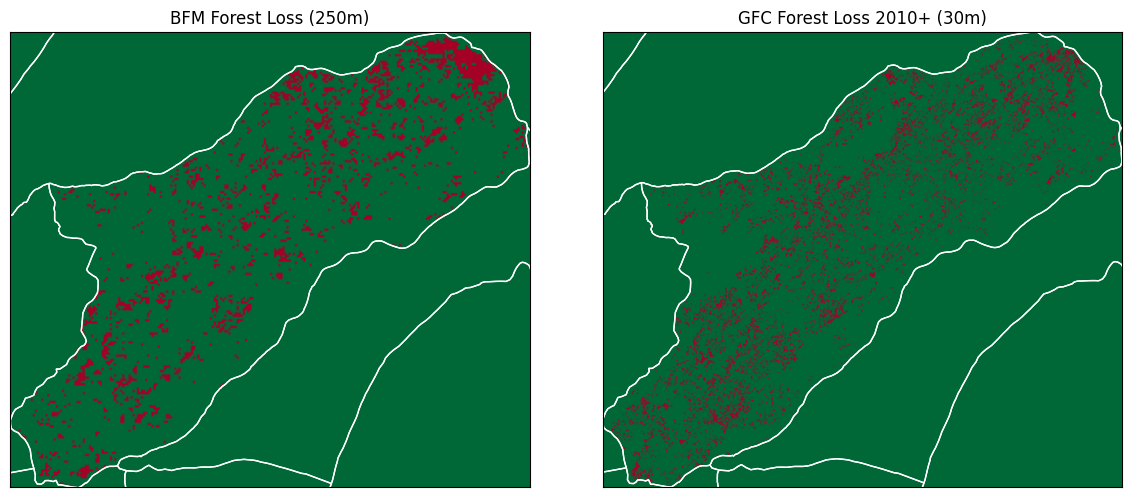

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# BFMのプロット
im1 = ax1.imshow(bfm_mask, cmap="RdYlGn_r", extent=extent_bfm)
aoi_clipped.boundary.plot(ax=ax1, edgecolor="white", linewidth=1)
ax1.set_title("BFM Forest Loss (250m)")
ax1.set_xticks([])
ax1.set_yticks([])

# GFCのプロット
im2 = ax2.imshow(gfc_mask, cmap="RdYlGn_r", extent=extent_gfc)
aoi_clipped.boundary.plot(ax=ax2, edgecolor="white", linewidth=1)
ax2.set_title("GFC Forest Loss 2010+ (30m)")
ax2.set_xticks([])
ax2.set_yticks([])

# BFMのプロット
ax1.set_xlim(extent_bfm[0], extent_bfm[1])
ax1.set_ylim(extent_bfm[2], extent_bfm[3])

# GFCのプロット
ax2.set_xlim(extent_gfc[0], extent_gfc[1])
ax2.set_ylim(extent_gfc[2], extent_gfc[3])

plt.tight_layout()
plt.show()

In [39]:
# Calculate areas (multiply pixel count by respective resolution squared)
bfm_area = np.sum(bfm_mask) * 0.25 * 0.25  # 250m resolution
gfc_area = np.sum(gfc_mask) * 0.03 * 0.03  # 30m resolution
# Print results
print(f"\nForest Loss Area Comparison:")
print(f"BFM-detected forest loss (250m): {bfm_area:.2f} km²")
print(f"GFC-detected forest loss (30m): {gfc_area:.2f} km²")


Forest Loss Area Comparison:
BFM-detected forest loss (250m): 170.88 km²
GFC-detected forest loss (30m): 137.87 km²
